# Rozpoznawanie organellów pochodzenia białek komórkowych drożdży na podstawie wyników 7 testów

Celem projektu jest stworzenie systemu zdolnego do odgadnięcia, z którego organellum drożdża pochodzi dane białko.
Zbiór danych treningowych został stworzony przez Kentę Nakai z Uniwerytetu Osakijskiego.
Dane zostały w przeszłości użyte do stworzenia systemu eksperckiego rozpoznającego pochodzenie białek drożdży.

Dane są zapisane w pliku tekstowym w kolumnach rozdzielonych zmienną liczbą spacji. Wartości są zeskalowane do przedziału <0-1>, więc możemy pominąć ten etap. Spis kolumn:
* nazwa białka w bazie danych SWISS-PROT
* mcg: wynik testu metodą McGeoch'a
* gvh: wynik testu metodą van Heijnego
* alm: wynik programu predykcyjnego ALOM dla białek transbłonowych
* mit: wynik analizy dyskryminacyjnej zawartości aminokwasów końca aminowego białek mitochondrialnych i niemitochondrialnych
* erl: obecność podłańcucha "HDEL" (wartość binarna)
* pox: PTS końca karboksylowego
* vac: wynik analizy dyskryminacyjnej zawartości aminokwasów końca aminowego białek wakuoli i pozakomórkowych
* nuc: wynik analizy dyskryminacyjnej NLS białek jądrowych i niejądrowych


## Wczytanie wartości

Z powodu nieregularnych odstępów między kolumnami konieczna była zamiana spacji na pojedynczą tabulację

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DecimalType

In [2]:
spark = SparkSession.builder.appName("yeast-classification").getOrCreate()

23/01/21 18:36:31 WARN Utils: Your hostname, Legion-Y540-15IRH-PG0 resolves to a loopback address: 127.0.1.1; using 192.168.100.13 instead (on interface wlp0s20f3)
23/01/21 18:36:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/21 18:36:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
with open("./data/yeast.data", "r") as file:
    data = file.read().replace('  ', ' ').replace('  ', ' ').replace(' ', "\t")
    file.close()
    with open("./data/my_yeast.data", "w") as new_file:
        new_file.write(data)

In [4]:
schema = StructType([
    StructField("name", StringType(), False),
    StructField("mcg", DecimalType(3,2), False),
    StructField("gvh", DecimalType(3,2), False),
    StructField("alm", DecimalType(3,2), False),
    StructField("mit", DecimalType(3,2), False),
    StructField("erl", DecimalType(3,2), False),
    StructField("pox", DecimalType(3,2), False),
    StructField("vac", DecimalType(3,2), False),
    StructField("nuc", DecimalType(3,2), False),
    StructField("loc", StringType(), False)
])
df = spark.read.csv("./data/my_yeast.data", header=False, schema=schema, sep='\t')

## Analiza liczebności klas

Zbiór nie jest zbalansowany. Oznacza to, że należy zwrócić uwagę na potencjalną niską dokładność wykrywania mniej popularnych przypadków.

In [5]:
df.createOrReplaceTempView("df")
spark.sql("SELECT loc, COUNT(*) AS elements FROM df GROUP BY loc ORDER BY elements DESC").show()

+---+--------+
|loc|elements|
+---+--------+
|CYT|     463|
|NUC|     429|
|MIT|     244|
|ME3|     163|
|ME2|      51|
|ME1|      44|
|EXC|      35|
|VAC|      30|
|POX|      20|
|ERL|       5|
+---+--------+



## Analiza podstawowego opisu stworzonego przez Pandas

W danych znajduje się 1484 białek i dane są kompletne. Wartości w każdej kolumnie mają dość wysokie odchylenie standardowe i pokrywają większość dostępnego przedziału 0-1. Umożliwi to dokładniejszą kategoryzację.

In [6]:
df.describe().toPandas()

,summary,name,mcg,gvh,alm,mit,erl,pox,vac,nuc,loc
0,count,1484,1484,1484,1484,1484,1484,1484,1484,1484,1484
1,mean,None,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199,None
2,stddev,None,0.13729930038958169,0.12392434900413829,0.08667024770783185,0.13709763089421423,0.04835096692671336,0.07568266520506631,0.057796586389259656,0.10649052826089457,None
3,min,6P2K_YEAST,0.11,0.13,0.21,0.00,0.50,0.00,0.00,0.00,CYT
4,max,ZUO1_YEAST,1.00,1.00,1.00,1.00,1.00,0.83,0.73,1.00,VAC


## Podział na dane testowe i treningowe

In [7]:
df_train, df_test = df.randomSplit([0.7, 0.3])

In [8]:
from pyspark.ml import feature

In [9]:
idx = feature.StringIndexer(inputCol="loc", outputCol="label")
idx_t = idx.fit(df_train)
df_train_ = idx_t.transform(df_train)

In [10]:
vect = feature.VectorAssembler(inputCols=df.columns[1:9], outputCol="features")
df_train_ = vect.transform(df_train_)

In [11]:
df_train_ = df_train_.select("label", "features")

## Stworzenie trzech modeli klasyfikacji

Użyto lasu losowego, regresji logistycznej i metody Bayesa.

Metoda lasu losowego polega na użyciu wielu drzew losowych. Algorytm polega na utworzeniu drzew o różnych konfiguracjach parametrów i trenowaniu ich tak samo, jak pojedynczego drzewa w procesie nadzorowanym. Wagi parametrów są poprawiane oddzielnie w każdym drzewie. Zakłada się, że statystycznie większość po wytrenowaniu będzie dawała poprawny wynik.

Wielomianowa Regresja logistyczna to rodzaj klasyfikacji metodą regresji dla wielu zmiennych. Regresja polega na odnalezieniu wielomianu, który jest bliski punktom należącym do danej klasy. W tym przypadku dopasowywana jest funkcja logistyczna, tj 1/(1+e^(-(x-m)/s), gdzie m i s to parametry a x to wektor danych.

Naiwny klasyfikator Bayesa to algorytm oparty na dystrybucji Gaussa. Każda cecha jest traktowana osobno i ma taką samą wagę. Model ten używa prawdopodobieństwa przynależności danej wartości do klasy.

In [12]:
from pyspark.ml import classification

In [13]:
forest = classification.RandomForestClassifier(maxDepth=8, minInstancesPerNode=5, seed=42)
forest_t = forest.fit(df_train_)
pred_train = forest_t.transform(df_train_)

In [14]:
bayes = classification.NaiveBayes(smoothing= 1.0, modelType="multinomial")
bayes_t = bayes.fit(df_train_)
bayes_pred_train = bayes_t.transform(df_train_)

In [15]:
logistic = classification.LogisticRegression()
logistic_t = logistic.fit(df_train_)
logistic_pred_train = logistic_t.transform(df_train_)

23/01/21 18:36:40 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


## Porównanie dokładności przyporządkowania z użyciem różnych metod

Dokładność lasu losowego jest największa, więc zostanie on użyty w systemie. Można zauważyć, że wszystkie systemy miały problem z dopasowaniem podgrup białek błonowych. Żadna z metod nie rozpoznawała białek wakuoli — drugiej najmniejszej grupy w zbiorze —, lecz dokładność przyporządkowania dla najmniej popularnej grupy retikulum endoplazmatycznego wynosiła ponad 50%.

Metoda Bayes'a sprawdziła się tylko do wykrywania białek cytoplazmy.

In [16]:
from pyspark.ml import evaluation

In [17]:
evaluator = evaluation.MulticlassClassificationEvaluator(metricName="accuracy")
forest_train_eval = evaluator.evaluate(pred_train)
print(f"Prawdopodobieństwo prawidłowego dopasowania lokalizacji z użyciem losowego lasu: {forest_train_eval}")
bayes_train_eval = evaluator.evaluate(bayes_pred_train)
print(f"Prawdopodobieństwo prawidłowego dopasowania lokalizacji z użyciem metody Bayesa: {bayes_train_eval}")
logistic_train_eval = evaluator.evaluate(logistic_pred_train)
print(f"Prawdopodobieństwo prawidłowego dopasowania lokalizacji z użyciem regresji logistycznej: {logistic_train_eval}")

Prawdopodobieństwo prawidłowego dopasowania lokalizacji z użyciem losowego lasu: 0.7033730158730159
Prawdopodobieństwo prawidłowego dopasowania lokalizacji z użyciem metody Bayesa: 0.3482142857142857
Prawdopodobieństwo prawidłowego dopasowania lokalizacji z użyciem regresji logistycznej: 0.6130952380952381


In [18]:
df_test_ = idx_t.transform(df_test)
df_test_ = vect.transform(df_test_)
df_test_ = df_test_.select("label", "features")
pred_eval = forest_t.transform(df_test_)
bayes_pred_eval = bayes_t.transform(df_test_)
logistic_pred_eval = logistic_t.transform(df_test_)

forest_test_eval = evaluator.evaluate(pred_eval)
bayes_test_eval = evaluator.evaluate(bayes_pred_eval)
logistic_test_eval = evaluator.evaluate(logistic_pred_eval)
print(f"Pradwopodobieństwo dopasowania lokalizacji białka dla zbioru nietrenowanego z użyciem losowego lasu: {forest_test_eval}")
print(f"Pradwopodobieństwo dopasowania lokalizacji białka dla zbioru nietrenowanego z użyciem metody Bayesa: {bayes_test_eval}")
print(f"Pradwopodobieństwo dopasowania lokalizacji białka dla zbioru nietrenowanego z użyciem regresji logistycznej: {logistic_test_eval}")

Pradwopodobieństwo dopasowania lokalizacji białka dla zbioru nietrenowanego z użyciem losowego lasu: 0.6029411764705882
Pradwopodobieństwo dopasowania lokalizacji białka dla zbioru nietrenowanego z użyciem metody Bayesa: 0.32983193277310924
Pradwopodobieństwo dopasowania lokalizacji białka dla zbioru nietrenowanego z użyciem regresji logistycznej: 0.5819327731092437


In [19]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['CYT', 'NUC', 'MIT', 'ME3', 'ME2', 'ME1', 'EXC', 'VAC', 'POX', 'ERL']

/home/toczownik/PycharmProjects/big_data/venv/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


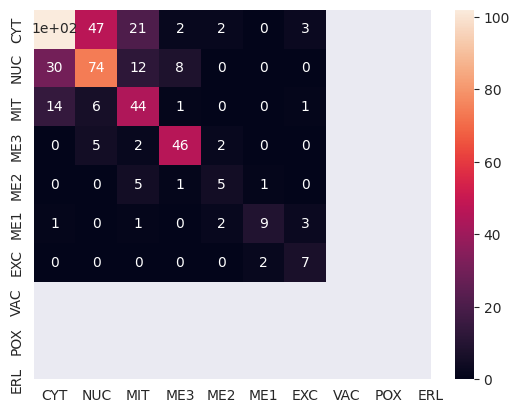

In [20]:
metrics = MulticlassMetrics(pred_eval.select(['label', 'prediction']).rdd.map(tuple))
confusion_matrix = metrics.confusionMatrix().toArray()
sns.heatmap(confusion_matrix, annot=True, xticklabels=labels, yticklabels=labels)
plt.show()

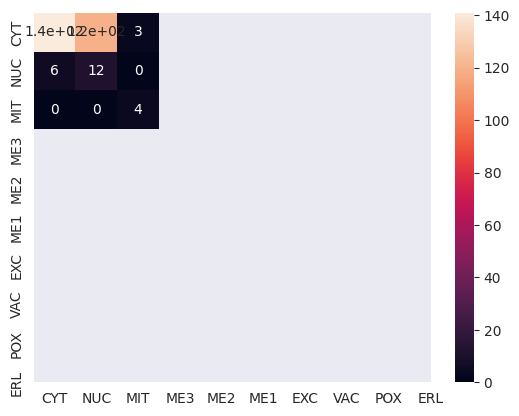

In [21]:
plt.close()
metrics = MulticlassMetrics(bayes_pred_eval.select(['label', 'prediction']).rdd.map(tuple))
confusion_matrix = metrics.confusionMatrix().toArray()
sns.heatmap(confusion_matrix, annot=True, xticklabels=labels, yticklabels=labels)
plt.show()

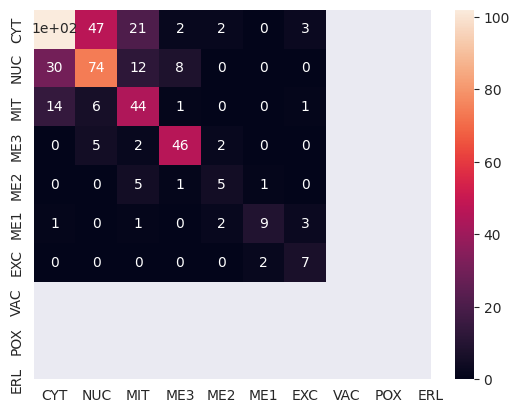

In [22]:
plt.close()
metrics = MulticlassMetrics(pred_eval.select(['label', 'prediction']).rdd.map(tuple))
confusion_matrix = metrics.confusionMatrix().toArray()
sns.heatmap(confusion_matrix, annot=True, xticklabels=labels, yticklabels=labels)
plt.show()

In [23]:
import pyspark.sql.functions as f
import numpy as np
me = df.filter(df.loc.isin('ME1', 'ME2', 'ME3'))
me1 = df.filter(df.loc == 'ME1')
me2 = df.filter(df.loc == 'ME2')
me3 = df.filter(df.loc == 'ME3')

metrics = ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']

averages = np.ndarray(shape=(4,8), dtype=float)
i = 0
for column in metrics:
    averages[0][i] = (sum(me.select(f.collect_list(column)).first()[0])/me.count())
    i = i + 1
i = 0
for column in metrics:
    averages[1][i] = (sum(me1.select(f.collect_list(column)).first()[0])/me1.count())
    i = i + 1
i = 0
for column in metrics:
    averages[2][i] = (sum(me2.select(f.collect_list(column)).first()[0])/me2.count())
    i = i + 1
i = 0
for column in metrics:
    averages[3][i] = (sum(me3.select(f.collect_list(column)).first()[0])/me3.count())
    i = i + 1

In [24]:
import pandas as pd
pd.DataFrame(data=averages, columns=metrics)

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.549341,0.557519,0.376318,0.243915,0.503876,0.0,0.510620,0.264845
1,0.788636,0.756591,0.376136,0.311818,0.500000,0.0,0.512955,0.268182
2,0.721569,0.603137,0.414902,0.282549,0.509804,0.0,0.510196,0.245490
3,0.430859,0.489509,0.364294,0.213497,0.503067,0.0,0.510123,0.270000


Trzy grupy białek transbłonowych są w większości pomiarów bardzo podobne do siebie, co tłumaczy problemy modelu z rozróżnianiem.

## Dlaczego metoda Bayesa działa najgorzej?

Dwie pozostałe metody miały bardzo zbliżone wyniki a o tym, która z nich sprawdziła się lepiej, decydował zbiór treningowy. Podejrzewamy, że w danych nie występuje rozrzut standardowy, co znacznie zmniejszyłoby dokładność tej metody. Hipoteza została sprawdzona na trzech klasach.

In [25]:
def show_dist(dataframe):
    for metric in metrics:
        sns.displot(data=dataframe.toPandas(), x=metric, kde=True)
    plt.show()

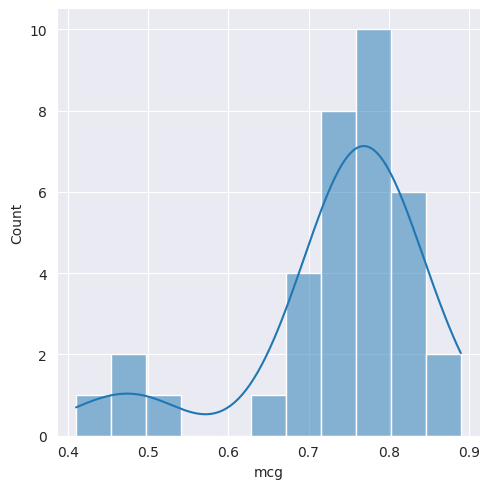

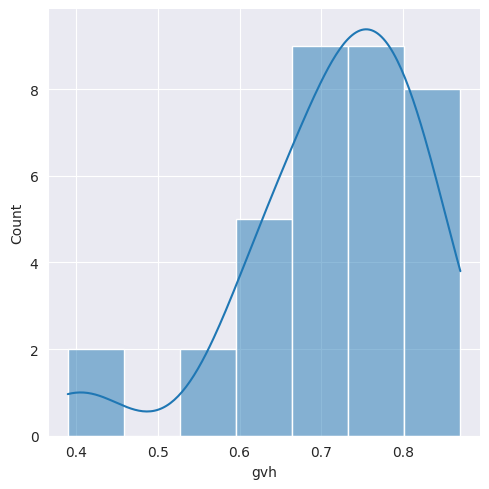

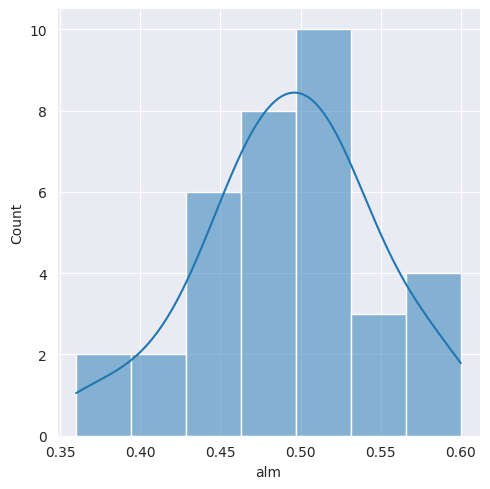

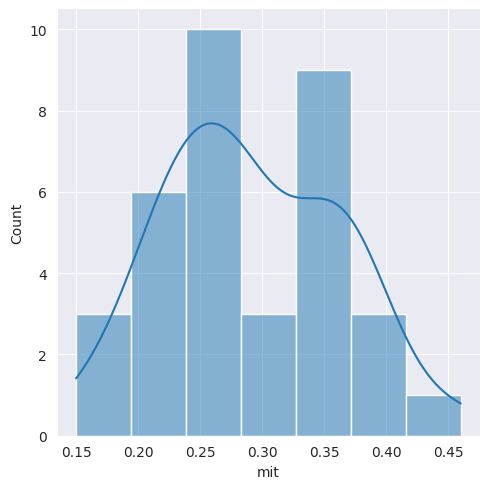

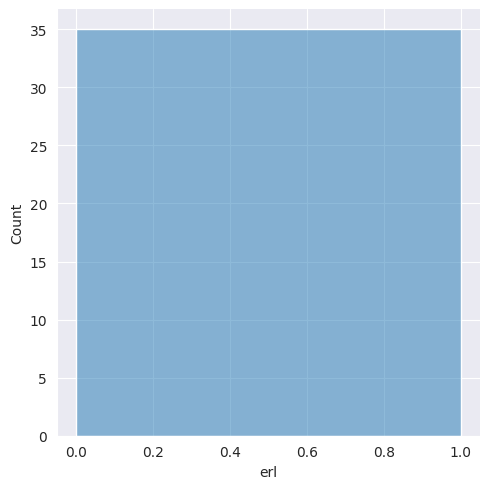

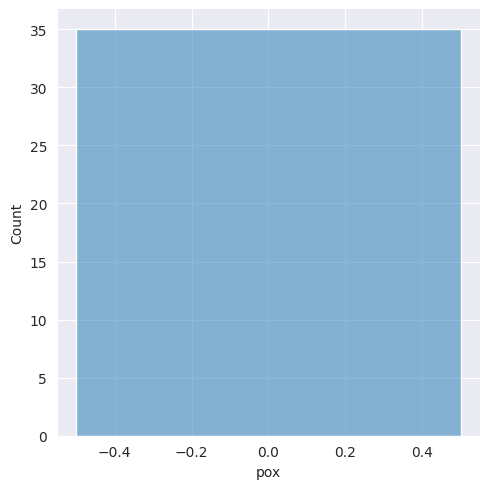

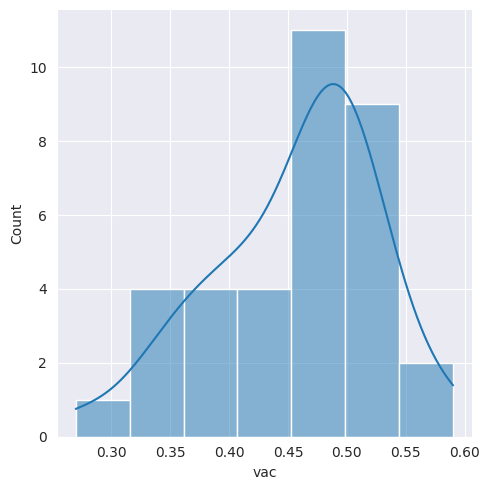

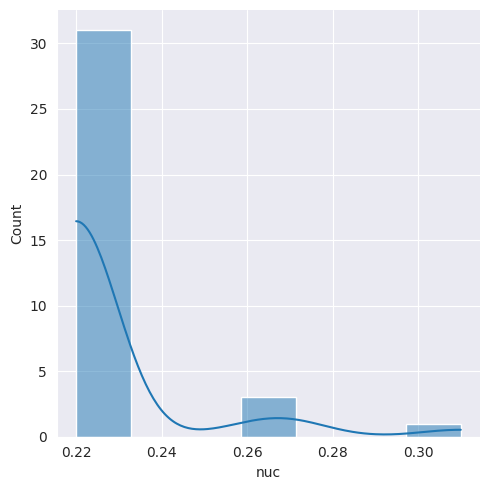

In [26]:
show_dist(df.filter(df.loc == 'EXC'))

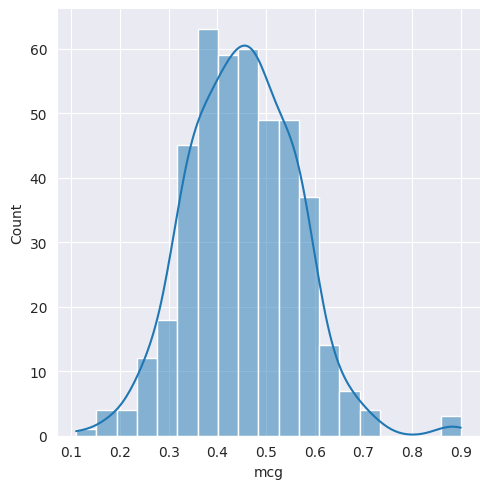

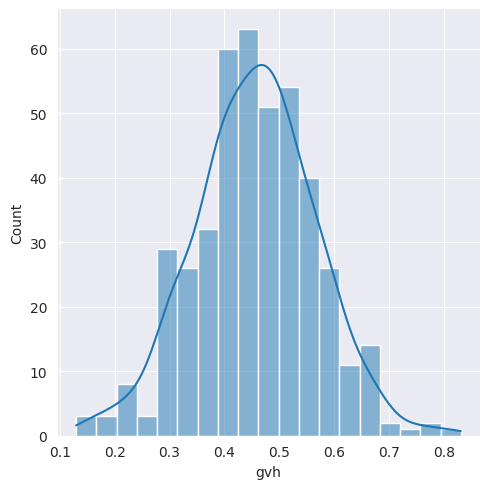

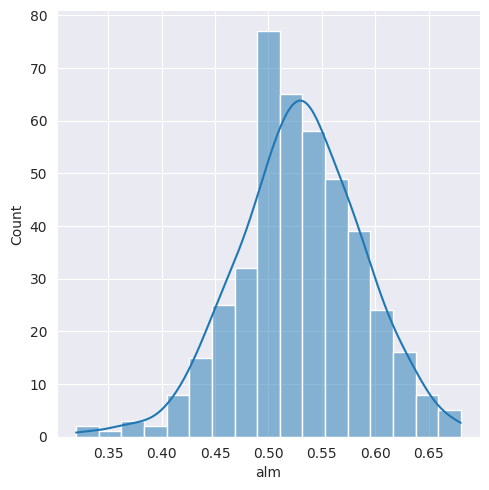

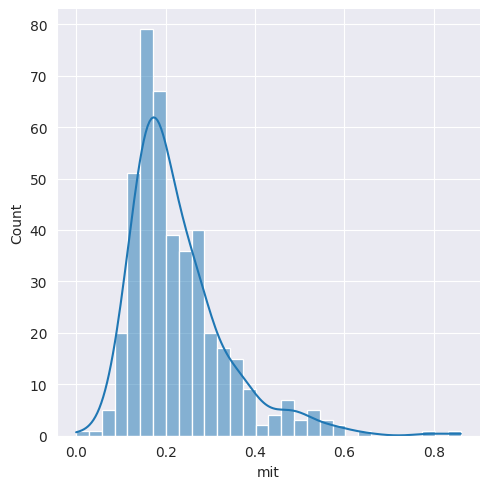

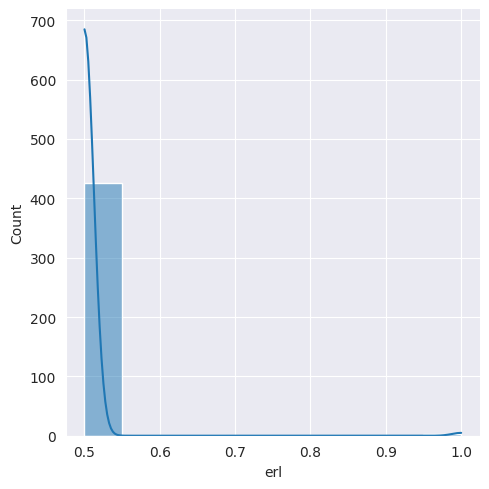

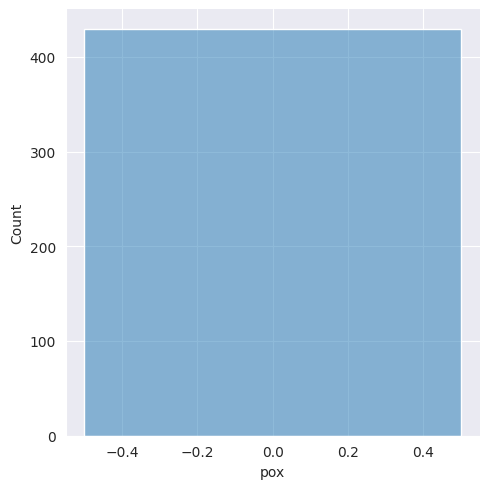

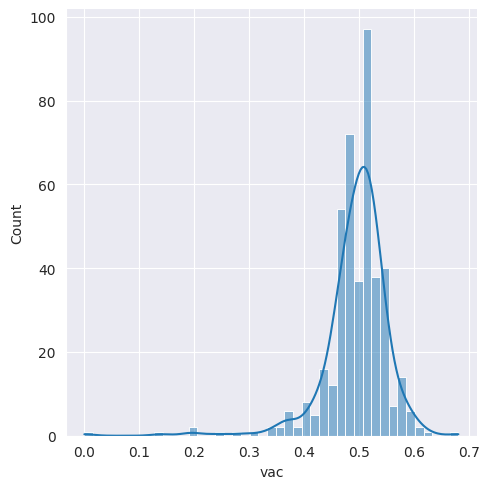

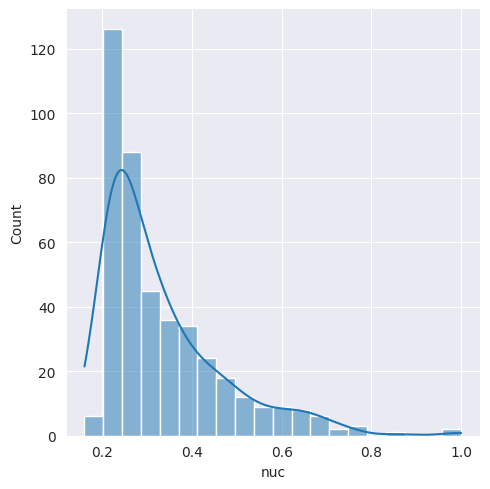

In [27]:
show_dist(df.filter(df.loc == 'NUC'))

Można zauważyć, że duża część danych jest rozłożona w sposób trudny do nauczenia dla metody Bayesa.

## Generacja modelu do użycia w działającym systemie

In [28]:
from pyspark.ml import Pipeline

pipe = Pipeline(stages=[idx, vect, forest])
pipe_t = pipe.fit(df)
pipe_t.write().overwrite().save("yeast_forest")